# Homework 4

### start by reading in the four starting images

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# unzip the faces.zip file into the folder containing Homework4.ipynb

# path to faces - need to reformat to work with your computer and operating system
path = './faces/'

# read in the four starting images
fisher   = plt.imread(path+'fisher.png')
stewart  = plt.imread(path+'stewart.png')
obama    = plt.imread(path+'obama.png')
cranston = plt.imread(path+'cranston.png')

# store the four faces in a list
# list with the 4 image matrices
face = [fisher, stewart, obama, cranston]
fnames = ['Fisher', 'Stewart', 'Obama', 'Cranston']
n_faces = len(face)

(fx, fy) = fisher.shape
flen = fx*fy
print('image size : ', fx, fy)

image size :  32 32


### view images

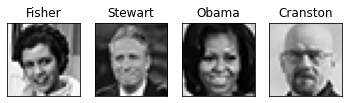

In [2]:
# view the four faces
for i in range(n_faces):
    plt.subplot(1, 4, i+1)
    plt.imshow(face[i], 'gray')
    plt.tick_params(axis='both', which='both',
                    bottom=False, top=False, labelbottom=False, 
                    right=False, left=False, labelleft=False)  
    plt.title(fnames[i])
plt.show()

### check image properties (values and types)

In [3]:
print('min pixel val of fisher : ', np.min(fisher))
print('max pixel val of fisher : ', np.max(fisher))
print('type in pixel : ', type(fisher[0,0]))

min pixel val of fisher :  0.0
max pixel val of fisher :  1.0
type in pixel :  <class 'numpy.float32'>


### center image around 0 and reshape into a 1D array rather than a 2D array

In [4]:
# preallocate numpy array to hold vectors of the four images
pats = np.zeros([n_faces, flen])

for i in range(n_faces):
    # reshape image
    p = face[i].reshape((flen,))
    
    # turn each image into a pattern ranging [-1 1]
    pats[i, :] = (p*2)-1
    
    # normalize each pattern to be unit length
    pats[i, :] = pats[i, :] / np.linalg.norm(pats[i, :])

### create noisy versions of each face to train network

In [5]:
import numpy.random as r

n_train = 500
noise_scale = 0.07
train_pats = np.zeros([n_train*n_faces, flen])

def noisy_versions (iterations, training_patterns, noise_scale):
    idx = 0
    for j in range(iterations):
        for i in range(n_faces):

            # normal noise with 0 mean and stdev #flen is 10*24 long
            unit_noise = r.randn(flen)*noise_scale

            # add face with noise to produce training data --> here you are generating the noise vector
            training_patterns[idx, :] = pats[i, :] + unit_noise

            # normalize activation to unit length
            training_patterns[idx, :] = training_patterns[idx, :] / np.linalg.norm(training_patterns[idx, :]) #linalg is a subpackage which is a part of numpy
            #sometimes functions live in packages while others live in subpackages

            idx += 1

    return training_patterns
            
original_train_pats = noisy_versions (n_train, train_pats, noise_scale)

### display some of the noisy training patterns

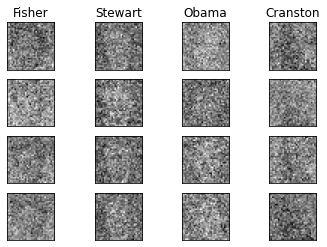

In [6]:
# you can play around with decreasing the noise level

for i in range(16):
    plt.subplot(4, 4, i+1)
    
    # reshape to square image
    this = original_train_pats[i, :].reshape([fx, fy])
    
    # convert back to [0 1] range
    this = (this+1)/2
    
    plt.imshow(this,'gray')
    
    plt.tick_params(axis='both',which='both',
          bottom=False,top=False,labelbottom=False,right=False,left=False,labelleft=False)   
    if i < 4:
        plt.title(fnames[i])

<hr>

<b>Q1.</b> Create a new 2000x4 numpy array called train_outs that has the “teacher” (output values you are training the network to reproduce) for each training pattern. For now, have the output of the correct answer equal to 1 and of the incorrect answers equal to 0.

Remember: You must not use hard-coded values. I have defined a lot of variables earlier in the code that you should use in your code.

In [7]:
each_out = np.full([n_faces, n_faces], -1) #create an array of -1's of width 4 and length 4 (in this case number of faces in the array that stores faces)

i = 0 
for each_row in each_out: #does a for loop through the n_face by n_face matrix
    each_row[i] = 1 #for every ith index it will plug in an 1
    i = i + 1 #i is iterated so that it can go through every index (0,1,2,3) in the each_out matrix
    
train_outs = np.concatenate([each_out, each_out]) #concatenating two of the matrixes together
size = int(train_outs.shape[0]/train_outs.shape[1]) #calculating the number of matrixes added together for the original 'train_outs'
for i in range ((n_train-size)): #a for loop to go through all n_train - size (in this case 498 iterations), and then concatenating each_out matrix to the previosly cocantenated one
    train_outs = np.concatenate([each_out, train_outs])

<hr>

<b>Q2.</b> Create a weight matrix with the appropriate dimensions. Initialize the weights in the matrix to random numbers drawn from a normal distribution. Normalize the weights so that the vector of weights contributing to the net input of any given output node has length equal to 1.

In [8]:
random_numbers = np.random.normal(loc=0.0, scale=1.0, size=(4,1024)) #creates a 4 by 1024 of random numbers from a normal distribution (the numbers range from -1 to 1)
weights = [] #intializing the empty weight list
for i in range(random_numbers.shape[0]): #goes through each random number in each row of the 4 by 1024 matrix
    norm1 = random_numbers[i]/ np.linalg.norm(random_numbers[i]) #normalizes each number in the row with respect to the numbers in that row
    weights.append(norm1) #append the norm1 vector (1 by 1024 normalized values) to the weights list
weights = np.asarray(weights) #converts the weight list to an array

sum1 = np.sum(np.square(weights[0])) #this shows that you normalized the vectors to a length equal to 1

<hr>

<b>Q3.</b> Train the network using Oja’s rule. As described in class, tor each of the 2000 patterns, the change in weight $Δw_{ij}$ between input node $i_{i}$ and output node $o_{j}$ is given by

$Δw_{ij} = λ \, i_{i} \, o_{j}$

where λ is the learning rate (assume λ = .01). If you stopped here, this would be Hebbian learning. For Oja’s rule, you will need to normalize the weights after updating the weights for each training pattern such that the vector of weights contributing to the net input of any given output node has length equal to 1 (you don’t normalize after every individual Δ$w_{ij}$ update, but after you update all the weights in the network).

Obviously, to train the network, you will need to write code to train the network. In Homework 3, we gave you Keras code to do the training. For this assignment, you need to write that training code from scratch. This should be only a few lines of code. It’s not complicated.

You do not need to worry about making your code efficient (vectorizing and the like) – you can if you want, but you do not have to. Slow is fine, so long as it runs correctly. Note that it will take a while to train the network (several minutes, depending on the speed of your computer). 

In [9]:
for index_image, each_image in enumerate(original_train_pats): #a for loop that go through each row (each image) of the original training patterns function 
    for each_neuron in range (n_faces): #goes through the indexes corresponding to each node  
        for index_pixel, each_pixel in enumerate(each_image): #go through every single value that composes each_image (flen = 32 by 32; so it goes through all 1024 digits)
            delta_weight = 0.01 * each_pixel * train_outs[index_image,each_neuron] #to calculate the delta weight, you need to multiply 0.01 by each pixel value multiplied by the correct 1 by 4 output vector
            weights[each_neuron, index_pixel] = weights[each_neuron, index_pixel] + delta_weight  #update the weight and then puts it back where it was found 
        weights[each_neuron] = weights[each_neuron]/np.linalg.norm(weights[each_neuron]) #just update the matrix; modification in place

<hr>

<b>Q4.</b> Visualize the weight going to each output unit of the network (like you did in Homework 3). You will need to produce four figures of “weight images”.

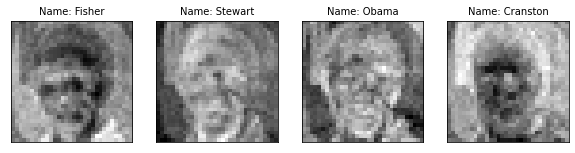

In [10]:
fig = plt.figure(figsize = (10,10)) #create figure
for idx in range(n_faces): #takes the index in the range of number of faces (i.e 0,1,2,3)
    plt.subplot(1,4, idx+1) #creates a subplot of 1 by 4
    new_W = weights[idx,:] #pulls the first row (1 node = 1 weight), and then the subsequent and so forth for plotting
    image_size = new_W.reshape(fx,fy) #reshapes it to a 32 by 32 array
    plt.imshow(image_size, cmap='gray', interpolation='none') #shows the plots
    plt.title("Name: {}".format(fnames[idx]), fontdict = {'fontsize': 10}) #formats the title of the image
    plt.xticks([]) #doesnt show the x marks
    plt.yticks([]) #doesnt show the y marks

<hr>

<b>Q5.</b> Test your trained network. First, present each original image to the network (the four identities). Second, present a new noisy version (using the same level of noise used during training) of each of these images to the network. For each test image presented to the network, print out the correct answer and the answer produced by the network (winner-take-all).

Try creating a new set of four test images (one for each identity) with a higher level of noise that used during training that causes the network to make classification errors.

In [11]:
total_original_outputs = [] #empty array that will contain the outputs of the 
total_noisy_outputs = []
total_high_level_noisy_outputs = []

iterations = 1
edited_pats = np.zeros([iterations*n_faces, flen])

def present_inputs (input_value, outputs): #input: takes the 4 original images that have been centered and normalized; the output stands for the empty list that will contain the output value (the dot product value)
    for each_image in input_value: #goes through every single image in the array that contains all the images
        output = np.dot(each_image, weights.T) #performs a dot product between the each image and the weights, which aks each node which input it is most confident in 
        outputs.append(output) #appends each list to one another
    outputs = np.asarray(outputs) #converts the outputs list to an array
    return outputs #returns the 4 by 4 output array

def correct_network_anw (inputs): #takes in the input: the 4 original images that have been centered and normalized
    for index, each_row in enumerate (inputs): #goes through each row in inputs
        print ("Correct Anwser:" + fnames[index]) #prints out the correct classification 
        index_face = np.where(each_row == np.max(each_row)) #finds the maximum activation value of each row
        index_face = int (index_face[0]) #converts the tuple to an integer
        network_anwser = fnames[index_face] #puts the index of the network's maximum activation value in fnames to see what is classified it as 
        print ("Network Anwser:" + network_anwser + "\n") #prints out the networks anwsers

print ("ORIGINAL IMAGE CLASSIFICATION" + "\n") #uses the functions above to print out the classification of the network vs. the correct anwser for each image
correct_network_anw(present_inputs(pats, total_original_outputs))

new_input = noisy_versions (1, edited_pats, 0.07)

print ("NOISY IMAGE CLASSIFICATION" + "\n") #uses the functions above to print out the classifications of the network vs. the correct anwser for each image with noise = 0.07
correct_network_anw(present_inputs (new_input, total_noisy_outputs))

last_input = noisy_versions (1, edited_pats, 0.53)

print ("HIGH LEVEL NOISY IMAGE CLASSIFICATION" + "\n") #uses the functions above to print out the classifications of the network vs. the correct anwser for each image with noise = 0.99
correct_network_anw(present_inputs(last_input, total_high_level_noisy_outputs))

ORIGINAL IMAGE CLASSIFICATION

Correct Anwser:Fisher
Network Anwser:Fisher

Correct Anwser:Stewart
Network Anwser:Stewart

Correct Anwser:Obama
Network Anwser:Obama

Correct Anwser:Cranston
Network Anwser:Cranston

NOISY IMAGE CLASSIFICATION

Correct Anwser:Fisher
Network Anwser:Fisher

Correct Anwser:Stewart
Network Anwser:Stewart

Correct Anwser:Obama
Network Anwser:Obama

Correct Anwser:Cranston
Network Anwser:Cranston

HIGH LEVEL NOISY IMAGE CLASSIFICATION

Correct Anwser:Fisher
Network Anwser:Fisher

Correct Anwser:Stewart
Network Anwser:Obama

Correct Anwser:Obama
Network Anwser:Stewart

Correct Anwser:Cranston
Network Anwser:Cranston



<hr>

<b>EXTRA CREDIT (2 point)</b>

See what happens when you change the coding for the output units from what was assumed above (the output of the correct answer equal to 1 and of the incorrect answers equal to 0) to a different coding of output units, with the output of the correct answer equal to 1 and the incorrect answers equal to -1). Retrain the network (like Q3), visualize the weights (like Q4), and test the network (like Q5).

Why does the visualization of the weights look different with this coding of output units from the one used in the main of the assignment? What is different about what is learned (and hence represented in the weights in the network) between the two ways of coding outputs? Add your written responses to a markdown cell in your assignment (an explanation is required to receive full extra credit).


<font size="8">In typical hebbian learning, you are multiplying the inputs by the teacher, which is denoted as 1 in the train_outs matrix, as seen by [0,1,0,0] for example. And wherever the teacher is 0, there is no deltaW for wherever the weight is not active, so if you are presented an image for Fisher in the weight (1 by 1024) that classifies Fisher, the fisher node will have an activation of 1,  but the cranston, obama, and stewart nodes will be denoted as 0, and therefore their delta weight will be 0 for that given weight. Therefore, the only weights that are going to change are the weights that are going to a specific node. However, when you replace the 0's with -1's, the delta weight for wherever the weight is not active, will no longer be 0, but rather be value going in the opposite direction. Therefore, unlike the one-hot vector which is [0,1,0,0], the -1, 1 coding will change ALL the weights --> the weights are going to change the winner on, turn the loser off, instead of causing the loser to be 0. This will lead to the images being different due to delta weight changing all the values of a given weight, including the the correct and incorrect ones.</font>